In [1]:
# _importing required libraries

import pandas as pd
import os
import string
import numpy as np
import hdbscan
import itertools
import json

import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import spacy

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from clusteval import clusteval

import texthero as hero
from texthero import preprocessing

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

import umap

import warnings
warnings.filterwarnings('ignore')

C:\Users\sri.sai.praveen.gadi\.virtualenvs\xxx-eAHl9Gue\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\sri.sai.praveen.gadi\.virtualenvs\xxx-eAHl9Gue\lib\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
C:\Users\sri.sai.praveen.gadi\.virtualenvs\xxx-eAHl9Gue\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMa

In [2]:
tf_model = hub.load(os.getcwd()+ '/../../models/USE_model')

1. Load complete candidate pool

In [6]:
def read_document_data(filepath):

    try:
        with open(filepath, 'r') as f:
            data_dict = json.load(f)
    except Exception as e:
        data_dict = dict()
        print(e)

    return data_dict

In [7]:
es_mr_data = read_document_data(os.getcwd()+'/../dataframes/search_results_index/mixed_reality_bm25_result.json')
ss_mr_data = read_document_data(os.getcwd()+'/../dataframes/search_results_index/mixed_reality_semantic_result.json')

In [11]:
cdd_page_id_list = list(set(list(es_mr_data.values()) + list(ss_mr_data.values())))

In [28]:
keywords_df = pd.read_pickle(os.getcwd()+'/final_keywords_dataframe.pkl')
# keywords_df = keywords_df[['id', 'keywords', 'lang']]
keywords_df = keywords_df.rename(columns={'id': 'page_id', 'nc_vec': 'mean_nc_vec', 'text_tokens': 'noun_chunks'})

In [29]:
cdd_df = keywords_df[keywords_df['page_id'].isin(cdd_page_id_list)]
cdd_df.sample(2)

,page_id,text,text_len,lang,noun_chunks,mean_nc_vec,label,label_name,title,pubDate,url,doc_repr_vec,keywords
8215,210705_news_91213,Absehbar werden Soldatinnen und Soldaten des D...,2040,de,"[Soldatinn, Soldat, der deutsch Heer, der komm...","[[-0.015945127233862877, 0.0007238469552248716...",1,technology,Anforderungen an das Militärische Nachrichtenw...,2020-02-03 07:49:48,https://esut.de/2020/02/fachbeitraege/streitkr...,"[-0.0020827926, 0.07501604, 0.05784911, 0.0053...","[(Bundeswehr, 0.2402372), (unterschiedlichst p..."
16408,210705_news_335781,S ome analysts fear the pandemic will spur a n...,838,en,"[s, analyst, the pandemic, a new kind, backlas...","[[-0.012484995648264885, -0.002218335401266813...",1,technology,Is this an age of division? Our research revea...,2020-10-29 15:15:23,https://www.theguardian.com/commentisfree/2020...,"[-0.008171351, -0.004745274, 0.06766033, -0.02...","[(the populist age, 0.13007826), (the YouGov..."


In [4]:
len(keywords_df.index)

26954

In [4]:
keywords_df.columns

Index(['page_id', 'text', 'text_len', 'lang', 'text_tokens', 'nc_vec', 'label',
       'label_name', 'title', 'pubDate', 'url', 'doc_repr_vec', 'keywords'],
      dtype='object')

In [5]:
main_df = pd.read_pickle(os.getcwd()+'/../dataframes/retrieval_dataset.pkl')

In [14]:
meta_data = []

for idx, row in main_df.iterrows():
    
    page_id = row['page_id']
    page_row = keywords_df[keywords_df['page_id'] == page_id]
    
    keywords = page_row['keywords'].values[0]
    lang = page_row['lang'].values[0]
    
    meta_data.append({
        'page_id': page_id,
        'query': row['query'],
        'label': row['label'],
        'text': row['text'],
        'text_len': row['text_len'],
        'noun_chunks': row['noun_chunks'],
        'mean_nc_vec': row['mean_nc_vec'],
        'title': row['title'],
        'published_date': row['published_date'],
        'source_url': row['source_url'],
        'keywords': keywords,
        'lang': lang
    })

In [16]:
len(meta_df.index)

629

In [15]:
meta_df = pd.DataFrame(meta_data)
meta_df.sample(2)

,page_id,query,label,text,text_len,noun_chunks,mean_nc_vec,title,published_date,source_url,keywords,lang
232,210705_news_305315,Satellitenkommunikation,2,SAN FRANCISCO – The U.S. Army plans to evaluat...,452,"[the U.S. Army, the performance, Isotropic Sys...","[[-0.011022232472896576, -4.06815015594475e-05...",US military to test Isotropic Systems antennas...,2020-09-24 09:08:33,https://spacenews.com/army-test-isotropic-ses/,"[(an SES geostationary satellite, 0.53605896),...",en
365,210705_news_337519,Defense,3,"Dublin, Nov. 03, 2020 (GLOBE NEWSWIRE) -- Th...",1016,"[Dublin, GLOBE NEWSWIRE, the ""Defense Drone A...","[[-0.011885600164532661, 0.010710920207202435,...",Global Defense Drone Antenna Market 2020-2027:...,2020-11-03 09:48:00,https://www.globenewswire.com/news-release/202...,"[(Global Defense Drone Antenna Market, 0.58164...",en


In [13]:
main_df.columns

Index(['page_id', 'query', 'label', 'text', 'text_len', 'noun_chunks',
       'mean_nc_vec', 'title', 'published_date', 'source_url'],
      dtype='object')

In [17]:
meta_df.to_pickle(os.getcwd()+'/../dataframes/final_xxx_dataset.pkl')

In [62]:
query_list = set(meta_df['query'].values)
query_df_folderpath = os.getcwd()+'/../dataframes/query_dataframes/'

for query in query_list:
    query_updated = query.lower().replace(' ', '_')
    filename = query_df_folderpath + f'{query_updated}_df.pkl'
    
    query_df = meta_df[meta_df['query'] == query]
    query_df.to_pickle(filename)

In [119]:
mr_df = main_df[main_df['query'] == 'Mixed Reality']
vs_df = main_df[main_df['query'] == 'Visualisierung']

In [120]:
mr_df = pd.concat([mr_df.set_index('page_id'), keywords_df.set_index('page_id')], axis=1, join='inner').reset_index()
vs_df = pd.concat([vs_df.set_index('page_id'), keywords_df.set_index('page_id')], axis=1, join='inner').reset_index()

### 1. keyword extraction
### 2. Candidate pool extraction

In [3]:
def get_modified_vectors(vec_data):
    
    new_data = []
    for val in vec_data:
        new_data.append(val)
    
    new_data = np.array(new_data).reshape(-1, 512)
    return new_data

def get_pool_vec(doc_vec_list, pool):
    
    doc_vec_list = get_modified_vectors(doc_vec_list)
    if pool == 'mean':
        return np.nanmean(doc_vec_list, axis=0)
    elif pool == 'max':
        return np.nanmax(doc_vec_list, axis=0)

def get_document_vec(text):
    
    return tf_model(text)['outputs'].numpy()[0].reshape(1, -1)

def get_sent_transformers_keywords_use(keywords, query_vec, max_keyword_cnt = 30):
    
    keywords = list(dict(keywords).keys())
    
    candidate_embeddings_keywords = [tf_model(kw)['outputs'].numpy()[0] for kw in keywords]
        
    query_distances = cosine_similarity([query_vec], candidate_embeddings_keywords)
    subtopic_keywords_dict = dict()
    for index in query_distances.argsort()[0][-max_keyword_cnt:]: 
        
        subtopic_keywords_dict[keywords[index]] = query_distances[0][index]
    
    subtopic_keywords_dict = sorted(subtopic_keywords_dict.items(), key=lambda x: x[1], reverse=True)

    return subtopic_keywords_dict

def get_candidate_pool(subtopic_keywords_list):
    
    candidate_pool = []
    
    lower_limit = 0.2
    upper_limit = 0.4
    
    for key, value in subtopic_keywords_list:
        
        if value > 0.2 and value < 0.4:
            candidate_pool.append(key)
            
    return candidate_pool

In [15]:
query_1 = 'Mixed Reality'
query_vec_1 = tf_model(query_1)['outputs'].numpy()[0]

query_2 = 'Visualisierung'
query_vec_2 = tf_model(query_2)['outputs'].numpy()[0]

In [121]:
%timeit mr_df['keywords_use'] = mr_df.apply(lambda x:get_sent_transformers_keywords_use(x['keywords'], query_vec_1, max_keyword_cnt = 30), axis=1)
%timeit vs_df['keywords_use'] = vs_df.apply(lambda x:get_sent_transformers_keywords_use(x['keywords'], query_vec_1, max_keyword_cnt = 30), axis=1)

31.5 s ± 443 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
%timeit mr_df['candidate_pool'] = mr_df.apply(lambda x:get_candidate_pool(x['keywords_use']), axis=1)
%timeit vs_df['candidate_pool'] = vs_df.apply(lambda x:get_candidate_pool(x['keywords_use']), axis=1)

32.4 s ± 680 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%timeit cdd_df['keywords_use'] = cdd_df.apply(lambda x:get_sent_transformers_keywords_use(x['keywords'], query_vec_1, max_keyword_cnt = 30), axis=1)

2min 21s ± 5.35 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%timeit cdd_df['candidate_pool'] = cdd_df.apply(lambda x:get_candidate_pool(x['keywords_use']), axis=1)

11.5 ms ± 339 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
# cdd_df.to_pickle(os.getcwd()+'/../dataframes/query_dataframes_cdd/retrieval_dataset_mr_cdd.pkl')
cdd_df = pd.read_pickle(os.getcwd()+'/../dataframes/query_dataframes_cdd/retrieval_dataset_mr_cdd.pkl')

In [14]:
df_xlm = pd.read_pickle(os.getcwd()+'/final_dataframe.pkl')
df_xlm = df_xlm[['id', 'lang']]
df_xlm = df_xlm.rename(columns={'id': 'page_id'})

In [16]:
mr_df = pd.concat([mr_df.set_index('page_id'), df_xlm.set_index('page_id')], axis=1, join='inner').reset_index()
vs_df = pd.concat([vs_df.set_index('page_id'), df_xlm.set_index('page_id')], axis=1, join='inner').reset_index()

In [24]:
mr_df.to_pickle(os.getcwd()+'/../dataframes/retrieval_dataset_mr.pkl')
vs_df.to_pickle(os.getcwd()+'/../dataframes/retrieval_dataset_vs.pkl')

In [5]:
mr_df = pd.read_pickle(os.getcwd()+'/../dataframes/retrieval_dataset_mr.pkl')
vs_df = pd.read_pickle(os.getcwd()+'/../dataframes/retrieval_dataset_vs.pkl')

In [23]:
def get_cdd_label(page_id):
    
    label = mr_df[mr_df['page_id'] == page_id]['label'].values
    if len(label) == 0:
        return 5
    else:
        return label[0]

In [30]:
cdd_df['label'] = cdd_df.apply(lambda x:get_cdd_label(x['page_id']) , axis=1)

In [31]:
cdd_df['query'] = mr_df['query'].values[0]

In [32]:
cdd_df.label.value_counts()

5    77
2    10
3     8
4     6
1     5
Name: label, dtype: int64

In [19]:
cdd_df.columns

Index(['page_id', 'text', 'text_len', 'lang', 'text_tokens', 'nc_vec', 'label',
       'label_name', 'title', 'pubDate', 'url', 'doc_repr_vec', 'keywords'],
      dtype='object')

In [18]:
mr_df.columns

Index(['page_id', 'query', 'label', 'text', 'text_len', 'noun_chunks',
       'mean_nc_vec', 'title', 'published_date', 'source_url', 'keywords',
       'keywords_use', 'candidate_pool', 'lang', 'entities'],
      dtype='object')

In [5]:
print(f'Retrieval score for Mixed reality: {mr_df.label.sum()}')
print(f'Retrieval score for Visualisierung: {vs_df.label.sum()}')

Retrieval score for Mixed reality: 73
Retrieval score for Visualisierung: 87


In [10]:
def get_irp(a, b):
    return ((a-b)/a)*100

In [21]:
nlp_de = spacy.load("de_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

In [19]:
def get_document_entities(text, lang):
    
    doc = None

    try:
        if len(text) >= 999999:
            return None

        if lang == 'en':
            doc = nlp_en(text)
        elif lang == 'de':
            doc = nlp_de(text)
        else:
            return None
        
        entities = []
        
        for ent in doc.ents:
            entities.append(ent.label_) 
    except Exception as e:
        return None
            
    return entities

In [23]:
mr_df['entities'] = mr_df.apply(lambda x:get_document_entities(x['text'], x['lang']),axis=1) 
vs_df['entities'] = vs_df.apply(lambda x:get_document_entities(x['text'], x['lang']),axis=1) 

In [4]:
def get_semantic_query_expectation(df):
    
    query = df['query'].values[0]
    query_vec = get_modified_vectors(tf_model(query)['outputs'].numpy()[0])
    
    df['query_sim'] = df.apply(lambda x:cosine_similarity(query_vec, x['mean_nc_vec'])[0][0], axis=1)
    df = df.sort_values(by=['query_sim'], ascending=False)
    
    exp_score_5 = exp_score_10 = exp_score_15 = exp_score_20 = exp_score_25 = 0
    
    for idx, row in df.iterrows():
        
        if row['label'] in [1, 2]:
            if idx <= 5:
                exp_score_5 += 1
            elif idx <= 10:
                exp_score_10 += 1
            elif idx <= 15:
                exp_score_15 += 1
            elif idx <= 20:
                exp_score_20 += 1
            elif idx <= 25:
                exp_score_25 += 1
    
    exp_score_10 += exp_score_5
    exp_score_15 += exp_score_10
    exp_score_20 += exp_score_15
    exp_score_25 += exp_score_20
    
    return  {
        'exp_5': exp_score_5,
        'exp_10': exp_score_10,
        'exp_15': exp_score_15,       
        'exp_20': exp_score_20,
        'exp_25': exp_score_25,
    }

In [33]:
get_semantic_query_expectation(mr_df)

{'exp_5': 2, 'exp_10': 5, 'exp_15': 7, 'exp_20': 11, 'exp_25': 14}

In [34]:
get_semantic_query_expectation(vs_df)

{'exp_5': 2, 'exp_10': 6, 'exp_15': 7, 'exp_20': 8, 'exp_25': 9}

In [21]:
mr_df.label.value_counts()

2    10
3     8
4     6
1     5
Name: label, dtype: int64

In [22]:
get_semantic_query_expectation(vs_df)

(1, 3, 1, 0, 0)

### 3. Clustering

In [42]:
keyword_vec_dictionary = dict()

In [5]:
keyword_vec_dictionary = dict()

def get_umap_output(vec_array, dim_size=5):
    
    umap_obj = umap.UMAP(n_neighbors=40, 
                        n_components=dim_size, 
                        min_dist=0.01,
                        metric='cosine',
                        random_state=123).fit(vec_array) 
    
    umap_output = umap_obj.transform(vec_array) 
    return umap_output, umap_obj

def get_hdbscan_output(data_points, min_cluster_size=20, min_samples=3):
    print(f'Min cluster size .... {min_cluster_size}')
    print(f'Min samples .... {min_samples}')

    hdbscan_output = hdbscan.HDBSCAN(
                                    min_cluster_size=min_cluster_size,
                                      min_samples=min_samples,
                                      metric='euclidean',
                                     cluster_selection_method='eom').fit(data_points)
    return hdbscan_output

def get_dbscan_output(data_points, cluster_size=7):
    
    dbscan_output = DBSCAN(
        #eps=3,
#                                       min_samples=2,
                                      metric='euclidean').fit(data_points)
    return dbscan_output

def project_on_2Dplane(umap_output, cluster_ids):
    
    umap_df = pd.DataFrame(np.column_stack((umap_output, cluster_ids)), columns=['x', 'y', 'cluster ids'])
    grid = sns.FacetGrid(umap_df, hue='cluster ids', height=7)
    grid.map(plt.scatter, 'x', 'y').add_legend()
    
def remove_noise(data_points, labels):
    
    data_points_filtered = []
    labels_filtered = []
    
    for dp, l in zip(data_points, labels):
        if l != -1:
            data_points_filtered.append(dp)
            labels_filtered.append(l)
            
    return data_points_filtered, labels_filtered
    
def get_clustering_analysis(cluster_df, final_candidate_pool_vecs, min_cluster_size=20, min_samples=3, dimen_size=5):
    
    umap_output_5, umap_5 = get_umap_output(final_candidate_pool_vecs, dim_size=dimen_size)
    hdbscan_output = get_hdbscan_output(umap_output_5, min_cluster_size, min_samples)
#     hdbscan_output = get_dbscan_output(umap_output_5, cluster_size=cluster_size)
    
    cluster_df['cluster_id'] = hdbscan_output.labels_
    data_points, labels = remove_noise(umap_output_5, hdbscan_output.labels_)
    sil_score = silhouette_score(data_points,labels,metric="euclidean",random_state=200)
    print(f'Silhouette score ... {sil_score}')
    
#     cluster_df.cluster_id.hist(bins=150)
    
    umap_output_2, umap_2 = get_umap_output(final_candidate_pool_vecs, dim_size=2)
#     project_on_2Dplane(umap_output_2, cluster_df['cluster_id'])
    
    return cluster_df

def get_nearest_keyword(keywords, keyword_vecs, mean_vec):
    
    query_distances = cosine_similarity([mean_vec], list(keyword_vecs))
    subtopic_keywords_dict = dict()
    for index in query_distances.argsort()[0]: 
        
        subtopic_keywords_dict[keywords[index]] = query_distances[0][index]
    
    subtopic_keywords_dict = sorted(subtopic_keywords_dict.items(), key=lambda x: x[1], reverse=True)
    return subtopic_keywords_dict[0][0]

def get_topics(cluster_data_df, candidate_pool):
    
    topic_list = []
    
    for idx, row in cluster_data_df.iterrows():
        
        candidate_words = row['candidate_words']
        topic = row['topic']
        
        for cp in candidate_pool:
            if cp in candidate_words:
                topic_list.append(topic)
                break
    
    return topic_list

def get_topic_documents(topic_words, final_df):
    
    doc_id_list = []
    for idx, row in final_df.iterrows():

        candidate_pool = row['candidate_pool']
        doc_id = row['page_id']

        for tw in topic_words:
            if tw in candidate_pool:
                doc_id_list.append(doc_id)

    return list(set(doc_id_list))

def get_meta_data(cluster_id, df, page_id_list):
    
    entity_list = []
    product_cnt = person_cnt = law_cnt = 0
    label_1 = label_2 = label_3 = label_4 = label_5 = 0
    page_len = len(page_id_list)
    
    for page_id in page_id_list:
#         entities = df[df['page_id'] == page_id]['entities'].values[0]
        
#         product_cnt += entities.count('PRODUCT')
#         person_cnt += entities.count('PERSON')
#         law_cnt += entities.count('LAW')
        
        label = int(df[df['page_id'] == page_id]['label'].values[0])
        
        if label == 1:
            label_1 += 1
        elif label == 2:
            label_2 += 1
        elif label == 3:
            label_3 += 1
        elif label == 4:
            label_4 += 1
        elif label == 5:
            label_5 += 1
            
    return {
        'cluster_id': cluster_id,
#         'product_cnt': product_cnt/page_len,
#         'person_cnt': person_cnt/page_len,
#         'law_cnt': law_cnt/page_len,
        'label_1': label_1,
        'label_2': label_2,
        'label_3': label_3,
        'label_4': label_4,   
        'label_5': label_5, 
    }

def get_sub_topic_modelling(query_df, min_cluster_size=20, min_samples=3):
    
    final_candidate_pool = []

    for idx, row in query_df.iterrows():
        final_candidate_pool.extend(row['candidate_pool'])
        
    final_candidate_pool = list(set(final_candidate_pool))
    print(f'Candidate keyword pool length .. {len(final_candidate_pool)}')
    
    final_candidate_pool_vecs = []
    for nc in final_candidate_pool:
        if nc not in keyword_vec_dictionary.keys():
            keyword_vec_dictionary[nc] = tf_model(nc)['outputs'].numpy()[0]
            
        final_candidate_pool_vecs.append(keyword_vec_dictionary[nc])
        
#     final_candidate_pool_vecs = [tf_model(nc)['outputs'].numpy()[0] for nc in final_candidate_pool]

    df_data = []
    for word, vec in zip(final_candidate_pool, final_candidate_pool_vecs):
        df_data.append((word, vec))

    cluster_df = pd.DataFrame(df_data, columns= ['candidate_words', 'candidate_vecs'])
    cluster_df = get_clustering_analysis(cluster_df, final_candidate_pool_vecs, min_cluster_size, min_samples, dimen_size=5)

    cluster_data = []

    for cluster_id in set(cluster_df.cluster_id.values):

        if cluster_id != -1:
            df = cluster_df[cluster_df['cluster_id'] == cluster_id]
            cluster_data.append((cluster_id, df.candidate_words.values, df.candidate_vecs.values))

    cluster_data_df = pd.DataFrame(cluster_data, columns=['cluster_id', 'candidate_words', 'candidate_vecs'])
    cluster_data_df['mean_vec'] = cluster_data_df.apply(lambda x:get_pool_vec(x['candidate_vecs'], 'mean'), axis=1)
    cluster_data_df['topic'] = cluster_data_df.apply(lambda x:get_nearest_keyword(x['candidate_words'], x['candidate_vecs'], x['mean_vec']), axis=1)

    cluster_data_df['page_id_list'] = cluster_data_df.apply(lambda x:get_topic_documents(x['candidate_words'], query_df), axis=1)
    cluster_data_df['doc_cnt'] = cluster_data_df.apply(lambda x:len(x['page_id_list']), axis=1)
    
    meta_data = []
    for idx, row in cluster_data_df.iterrows():
        meta_data.append(get_meta_data(row['cluster_id'], query_df, row['page_id_list']))
        
    entity_df = pd.DataFrame(meta_data)
    cluster_data_df = pd.concat([cluster_data_df.set_index('cluster_id'), entity_df.set_index('cluster_id')], axis=1, join='inner').reset_index()
    
    return cluster_data_df

## External target function analysis

In [6]:
def get_covered_doc_data(page_id_list, df):
    
    covered_df = df[df['page_id'].isin(page_id_list)]
    covered_df = covered_df[covered_df['label'].isin([1, 2])]    
    
    return len(covered_df.index)
    
    
def calculate_expectation(cluster_dict, df, n_results):
    
    cluster_data = np.array(list(cluster_dict.keys()))
    
#     print(f'Running n_results, cluster_cnt ... {n_results} -- {len(cluster_data)}\n')
    
    all_combinations = []

    if len(cluster_dict) < 7:
        all_combinations = list(itertools.permutations(cluster_data))
    else:
        while len(set(all_combinations)) < 1000:
            all_combinations.append(tuple(np.random.permutation(cluster_data)))
            
    list_of_found_relevant_doc_per_permutation = []
    for comb in all_combinations:
        
        number_of_found_relevant_docs = 0
        number_of_inspected_docs = 0
        
        page_id_covered = []
        
        for cluster in comb:
            page_id_covered.extend(cluster_dict[cluster])
            page_id_covered = list(set(page_id_covered))
            
            if number_of_inspected_docs > n_results:
                break
            else:
                covered_pos_docs = get_covered_doc_data(page_id_covered, df)
                covered_docs = len(page_id_covered)
                
#                 print(f'Covered_docs and pos docs ... {covered_docs} ---- {covered_pos_docs}')

                number_of_inspected_docs = len(set(page_id_covered))
                number_of_found_relevant_docs = covered_pos_docs
                
        list_of_found_relevant_doc_per_permutation.append(number_of_found_relevant_docs)
                
    return sum(list_of_found_relevant_doc_per_permutation) / len(list_of_found_relevant_doc_per_permutation)

def get_cluster_expectation_scores(cluster_df, df):
    
    cluster_dict = dict()
    
    for idx, row in cluster_df.iterrows():
        cluster_dict[row['cluster_id']] = row['page_id_list']
        
    return {
        'exp_5': calculate_expectation(cluster_dict, df, n_results=5),
        'exp_10': calculate_expectation(cluster_dict, df, n_results=10),
        'exp_15': calculate_expectation(cluster_dict, df, n_results=15),       
        'exp_20': calculate_expectation(cluster_dict, df, n_results=20),
        'exp_25': calculate_expectation(cluster_dict, df, n_results=25),
    }

def get_document_labels(page_id_list, df):
    
    label_1 = label_2 = label_3 = label_4 = label_5 = 0
    for page_id in list(page_id_list):
        
        label = df[df['page_id'] == page_id]['label'].values[0]
        
        if label == 1:
            label_1 += 1
        elif label == 2:
            label_2 += 1
        elif label == 3:
            label_3 += 1
        elif label == 4:
            label_4 += 1
        elif label == 5:
            label_5 += 1
            
    return label_1, label_2, label_3, label_4, label_5

def get_elimination_cluster_cnt(cluster_df, df):
    
    cluster_cnt_eliminated = 0
    neg_doc_eliminated = []
    query = df['query'].values[0]
    
    negative_page_id_list = []
    for page_id, label in zip(df.page_id.values, df.label.values):
        if label == 3 or label == 4:
            negative_page_id_list.append(page_id)
        
    total_doc_cnt = len(set(negative_page_id_list))
    
    for idx, row in cluster_df.iterrows():
        
        label_1 = row['label_1']
        label_2 = row['label_2']
        label_3 = row['label_3']
        label_4 = row['label_4']
        label_5 = row['label_5']
        
        criteria = 2*label_2 - (label_3+label_4)
        if label_1 == 0 and criteria < 0:
            
            cluster_cnt_eliminated += 1
            common_neg_docs = list(set(negative_page_id_list) & set(row['page_id_list']))
            neg_doc_eliminated.extend(common_neg_docs)
    
    targeted_doc_cnt = len(set(neg_doc_eliminated))
    
    clustered_page_id_list = []
    for id_list in cluster_df.page_id_list.values:
        clustered_page_id_list.extend(id_list)
    
    cluster_page_ids = set(clustered_page_id_list)
    all_page_ids = set(df.page_id.values)
    
    clustering_loss = all_page_ids - cluster_page_ids
    missed_documents = get_document_labels(clustering_loss, df)
    
#     expectation_data = get_cluster_expectation_scores(cluster_df, df)
    
    return {
        'Query': query,
        'No.of clusters': len(cluster_df.index),
        'No.of clusters': cluster_cnt_eliminated,
        'Targeted neg doc': targeted_doc_cnt,
        'Total neg doc': total_doc_cnt,
        'ratio of targeted doc': round((targeted_doc_cnt/total_doc_cnt) * 100, 2),
        'missed_label_1': missed_documents[0],
        'missed_label_2': missed_documents[1],
        'missed_label_3': missed_documents[2],
        'missed_label_4': missed_documents[3],
        'missed_label_5': missed_documents[4],
    }

## Smaller Candidate pool

1. Top 30
2. Manual Labels: [1, 2, 3, 4]


In [12]:
columns = ['cluster_id', 'topic','doc_cnt','label_1','label_2','label_3','label_4', 'label_5']

In [21]:
cluster_data_df_mr = get_sub_topic_modelling(mr_df, min_cluster_size=10, min_samples=5)

cluster_data_df_mr[columns]
# cluster_data_df_vs = get_sub_topic_modelling(vs_df)

Candidate keyword pool length .. 282
Min cluster size .... 10
Min samples .... 5
Silhouette score ... 0.42184707522392273


,cluster_id,topic,doc_cnt,label_1,label_2,label_3,label_4,label_5
0,0,3D-Druck,8,2,4,2,0,0
1,1,a simulation model,5,3,0,1,1,0
2,2,VR,12,4,4,4,0,0
3,3,"ubiquitous, diversity-relate training",9,2,2,3,2,0
4,4,nucleation rate,3,0,0,1,2,0
5,5,algebra,3,0,0,0,3,0
6,6,autonomous platform,6,1,0,3,2,0
7,7,technology,10,1,2,6,1,0
8,8,der Wahrnehmung,24,5,8,8,3,0


In [16]:
pd.DataFrame([get_elimination_cluster_cnt(cluster_data_df_mr, mr_df)])

,Query,No.of clusters,Targeted neg doc,Total neg doc,ratio of targeted doc,missed_label_1,missed_label_2,missed_label_3,missed_label_4,missed_label_5
0,Mixed Reality,2,5,14,35.71,0,0,0,0,0


## Larger Candidate pool

1. Top 100
2. Labels: [1, 2, 3, 4, 5]
3. Un-labeled label: 5

In [23]:
cluster_data_df_mr_cdd = get_sub_topic_modelling(cdd_df, min_cluster_size=15, min_samples=5)

cluster_data_df_mr_cdd[columns]

Candidate keyword pool length .. 913
Min cluster size .... 15
Min samples .... 5
Silhouette score ... 0.6605446934700012


,cluster_id,topic,doc_cnt,label_1,label_2,label_3,label_4,label_5
0,0,a simulation model,25,3,0,2,1,19
1,1,VR,27,4,4,3,0,16
2,2,3D,12,2,1,2,0,7
3,3,LTAMDS,20,0,3,2,0,15
4,4,algorithm,14,0,0,0,3,11
5,5,Animation,15,0,1,4,1,9
6,6,technology,15,1,2,5,1,6
7,7,Sehstärke,10,2,5,1,0,2
8,8,terrain,20,0,0,3,1,16
9,9,der Klimawandel,6,0,0,0,0,6


In [105]:
pd.DataFrame([get_elimination_cluster_cnt(cluster_data_df_mr_cdd, cdd_df)])

,Query,No.of clusters,Targeted neg doc,Total neg doc,ratio of targeted doc,missed_label_1,missed_label_2,missed_label_3,missed_label_4,missed_label_5
0,Mixed Reality,5,10,14,71.43,0,1,1,0,1


In [12]:
keywords_cdd_df = []

for keywords in cdd_df.keywords.values:
    for kw in keywords:
        keywords_cdd_df.append(kw[0])
        
keywords_cdd_df = list(set(keywords_cdd_df))

In [14]:
keywords_cdd_df.sort()

In [157]:
def get_elimination_pool(df, column_name, quantile):
    
    df = df[df[column_name] > quantile]
    
    elimination_pool = []
    for page_id in df.page_id_list.values:
        elimination_pool.extend(page_id)
    
    return list(set(elimination_pool))

In [158]:
def get_retrieval_updates(percentile):
    
    law_cnt_75 = cluster_data_df_mr.law_cnt.quantile(percentile)
#     person_cnt_75 = cluster_data_df_mr.person_cnt.quantile(percentile)
    product_cnt_75 = cluster_data_df_mr.product_cnt.quantile(percentile)

    law_elimination_pool = get_elimination_pool(cluster_data_df_mr, 'law_cnt', law_cnt_75)
#     person_elimination_pool = get_elimination_pool(cluster_data_df_mr, 'person_cnt', person_cnt_75)
    product_elimination_pool = get_elimination_pool(cluster_data_df_mr, 'product_cnt', product_cnt_75)

    elimination_pool = list(set(law_elimination_pool) & set(product_elimination_pool))

    elm_df = mr_df[mr_df['page_id'].isin(elimination_pool)]
    print(elm_df.label.value_counts())

In [24]:
for prnt in np.arange(0.1, 1, 0.02):
    
    prnt = round(prnt, 2)
    print(f'\n{prnt} ==== ')
    get_retrieval_updates(prnt)

## Silhouette index vs Target function

1. Min-max normalize Silhouette index:  [-1, 1] to [0, 1]
2. Min-max normalize Ratio of targeted doc: [0, 100] to [0, 1] 
3. Small cdd vs Large cdd (Correlation between Silhouette index & Targeted doc ration, Mean silhouette score, Mean ratio of targeted doc)
4. Updated candidate noun-chunk extraction
5. Cluster tuning -- pending

In [55]:
data_anamoly_queries = ['Kryptologie', 'Defense', 'Cyber Attack', 'Data Centric Warfare', 'unbemannte Wirksysteme']

In [60]:
def get_cdd_analysis(filepath):
    
    cdd_df = pd.read_excel(filepath)
    cdd_df = cdd_df[~cdd_df['Query'].isin(data_anamoly_queries)]
    cdd_df = cdd_df[['Query', 'Cluster cnt', 'Silhouette score', 'Ratio of targeted doc']]
    
    cdd_df['Silhouette score'] = MinMaxScaler().fit_transform(cdd_df[["Silhouette score"]])
    cdd_df['Ratio of targeted doc'] = MinMaxScaler().fit_transform(cdd_df[["Ratio of targeted doc"]])
    
    corr_score = round(cdd_df['Silhouette score'].corr(cdd_df['Ratio of targeted doc']), 3)
    mean_silhouette_score = round(cdd_df['Silhouette score'].mean(), 3)
    mean_targeted_doc_ratio = round(cdd_df['Ratio of targeted doc'].mean(), 3)
    
    print(f'Correlation score: {corr_score}')
    print(f'Mean silhouette score: {mean_silhouette_score}')
    print(f'Mean targeted neg doc score: {mean_targeted_doc_ratio}')
    
    return cdd_df

In [61]:
small_cdd = get_cdd_analysis(os.getcwd()+'/../dataframes/hdbscan_cluster_dataframes_updated_nc/hdbscan_clustering_output_df_1.xlsx')
small_cdd

Correlation score: 0.381
Mean silhouette score: 0.667
Mean targeted neg doc score: 0.608


,Query,Cluster cnt,Silhouette score,Ratio of targeted doc
0,Kommunikationsnetze,14,0.858651,0.89474
1,Waffen Systeme,15,0.790832,0.00000
2,Mixed Reality,18,0.945461,0.57143
3,IT-Standards,21,0.779808,0.95000
4,Schutz von unbemannten Systemen,14,0.413681,0.00000
5,Robotik,11,0.000000,0.00000
6,Edge computing,20,0.935494,1.00000
8,militärische Entscheidungsfindung,18,0.556746,1.00000
9,Satellitenkommunikation,13,0.460894,1.00000
10,Visualisierung,17,0.429806,0.57143


In [62]:
large_cdd = get_cdd_analysis(os.getcwd()+'/../dataframes/hdbscan_cluster_dataframes_updated_nc_cdd/hdbscan_clustering_output_df_cdd_1.xlsx')
large_cdd

Correlation score: -0.173
Mean silhouette score: 0.586
Mean targeted neg doc score: 0.748


,Query,Cluster cnt,Silhouette score,Ratio of targeted doc
0,Kommunikationsnetze,43,0.717574,1.00000
1,Waffen Systeme,45,0.343508,0.00000
2,Mixed Reality,72,0.928280,1.00000
3,IT-Standards,73,0.892253,0.80000
4,Schutz von unbemannten Systemen,62,0.287828,1.00000
5,Robotik,51,0.414790,1.00000
6,Edge computing,61,0.574326,1.00000
8,militärische Entscheidungsfindung,59,0.923608,1.00000
9,Satellitenkommunikation,44,0.432496,1.00000
10,Visualisierung,47,0.000000,1.00000


# Threshold analysis

In [52]:
thresholds = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]

query_1 = [2, 9, 21, 41, 76, 97, 100, 100, 100, 100] # _Big Data, KI für Analyse
query_2 = [1, 2, 3, 6, 16, 36, 77, 97, 100, 100] # _Wellenformen und -ausbreitung

query_3 = [2, 4, 5, 8, 26, 81, 199, 100, 100, 100] # _Resiliente Kommunikationsverbünde
query_4 = [2, 5, 12, 26, 79, 100, 100, 100, 100, 100] # _Wetterdatenfusion
query_5 = [1, 4, 13, 35, 82, 99, 100, 100, 100, 100] # _Taktische Datenlinks

data_list = []
for idx in range(len(thresholds)):
    data_list.append((thresholds[idx], query_1[idx], query_2[idx], query_3[idx], query_4[idx], query_5[idx]))

,Threshold multiplier,Query 1,Query 2,Query 3,Query 4,Query 5
0,0.95,2,1,2,2,1
1,0.90,9,2,4,5,4
2,0.85,21,3,5,12,13
3,0.80,41,6,8,26,35
4,0.75,76,16,26,79,82
5,0.70,97,36,81,100,99
6,0.65,100,77,199,100,100
7,0.60,100,97,100,100,100
8,0.55,100,100,100,100,100
9,0.50,100,100,100,100,100


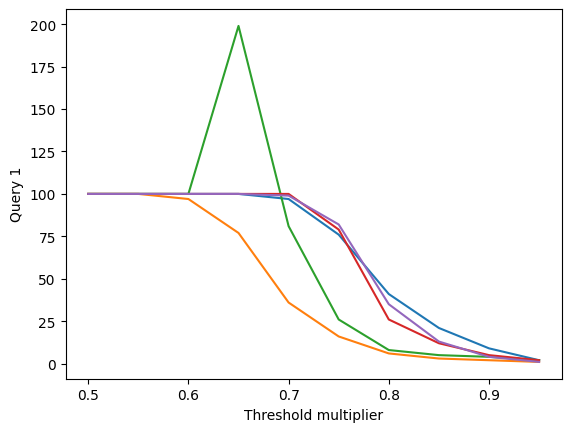

In [53]:
threshold_df = pd.DataFrame(data_list, columns=['Threshold multiplier', 'Query 1', 'Query 2', 'Query 3', 'Query 4', 'Query 5'])

for idx in range(1, 6):
    
    sns.lineplot(data=threshold_df, x="Threshold multiplier", y=f"Query {idx}", err_style="bars", errorbar=("se", 2), markers=True, dashes=False)

threshold_df

In [60]:
[round(val,2) for val in np.arange(0.5, 1.0, step=0.01)]

[0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69,
 0.7,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.82,
 0.83,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.94,
 0.95,
 0.96,
 0.97,
 0.98,
 0.99]